# Trajectory Clustering with cuSpatial and cuML

The task of this notebook is grouping a set of trajectories in such a way that trajectories in the same group are more similar to each other than to those in other groups.

The clustering task is performed in two separate steps:
1. Calculate the similarity between all trajectory pairs and caches the result. 
2. Apply searching algorithm on the pre-computed similarity matrix. Here we tried two algorithms: AgglomerativeClustering (AC) and DBSCAN.

Since the search algorithm require certain hyperparamter tunings to achieve the best result, in every iteration of tuning, we would like to reuse the results from the previous step.

### How cuSpatial and cuML helps:
This example uses cuSpatial Hausdorff distance to significantly accelerate the similarity metric computation on the GPU and cuML to significantly accelerate the clustering computation with AC and DBSCAN on the GPU.

In [1]:
import os
import random
import time
import pickle

import numpy as np
import cupy as cp
from ipywidgets import interact, widgets
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib import gridspec
from skimage import io

import cuspatial
import cuml

## Load preprocessed trajectories

The real-world trajectory dataset we used here for this example is collected from a traffic intersection located in Dubuque, Iowa.
We applied the following steps to extract vehicle trajectories from multiple cameras implemented at this intersection:

- Detect vehicle locations in camera domain using AI based detectors
- Apply tracking algorithm to assign the same id to the same vehicle
- Project the vehicle location from camera domain to latitudes and longitudes
- Create trajectories based on vehicle id

This dataset provided by NVIDIA is under the [Creative Commons 4.0 Attribution-ShareAlike 4.0 International license](https://creativecommons.org/licenses/by-sa/4.0/).

In [2]:
!if [ ! -f "trajectories_extracted.p" ]; then curl -o trajectories_extracted.p "https://data.rapids.ai/cuspatial/datasets/trajectories_extracted.p"; else echo "trajectories_extracted.p found"; fi

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 27.5M  100 27.5M    0     0  60.9M      0 --:--:-- --:--:-- --:--:-- 61.4M


In [3]:
with open('trajectories_extracted.p', 'rb') as f:
    trajectories = pickle.load(f)


## Define trajectory transform functions

In [4]:
def latlon_to_image_coord(lat, long):
    """Convert coordinate from latlon space to image space."""
    x_anchor = 436.369
    y_anchor = 126.613
    long_anchor = -90.666714
    lat_anchor = 42.492466

    long_1 = -90.663183
    lat_1 = 42.491671
    x_1 = 971.026
    y_1 = 291.955

    long_2_x_rate = (x_1 - x_anchor) / (long_1 - long_anchor)
    lat_2_y_rate = (y_1 - y_anchor) / (lat_1 - lat_anchor)

    y = (lat - lat_anchor) * lat_2_y_rate + y_anchor
    x = (long - long_anchor) * long_2_x_rate + x_anchor

    return x, y


def traj_coord_to_image_coord(traj):
    """Transform trajectory coordinates to image coordinate."""
    traj_image = [
        latlon_to_image_coord(
            lat, long
        ) for lat, long in traj
    ]

    return np.asarray(traj_image)


def traj_filter_num_points(trajectories, num_min):
    """Filter short trajectories"""
    max_length = 0
    min_length = 999

    long_trajectories = [traj for traj in trajectories if len(traj) >= num_min]
    lengths = [len(traj) for traj in long_trajectories]
    max_length = max(len(traj) for traj in trajectories)
    min_length = min(lengths)

    print("the longest traj length is: ", max_length)
    print("the shortest traj length is: ", min_length)
    print("the average traj length is: ", int(np.mean(lengths)))
    return long_trajectories


def pick_traj_with_label(pick, labels, trajectories):
    """Filter trajectory by labels"""
    selected_trajectories = [
        traj for traj_label, traj in zip(labels, trajectories) if traj_label == pick
    ]
    return selected_trajectories


## Filter and transform trajectories

In [5]:
print('Filtering based on number of points ...')
trajectories = traj_filter_num_points(trajectories, num_min=30)
print(f'{len(trajectories)} left after filtering based on number of points')

trajectories = [traj_coord_to_image_coord(
    trajectory) for trajectory in trajectories]


Filtering based on number of points ...
the longest traj length is:  961
the shortest traj length is:  30
the average traj length is:  87
10070 left after filtering based on number of points


## Visualize the filtered trajectories

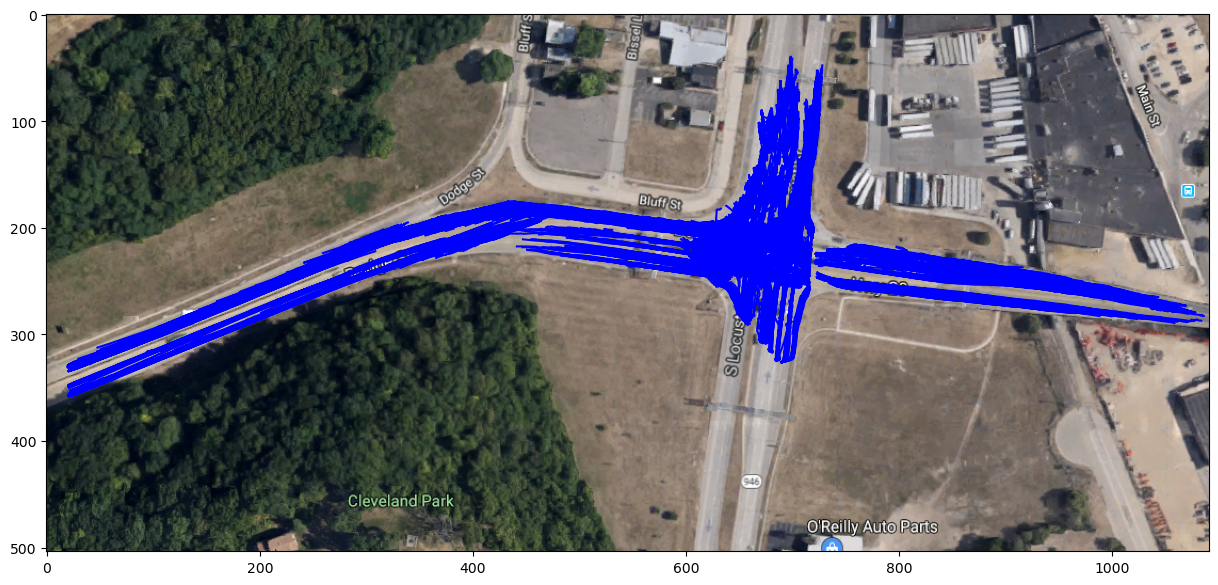

In [6]:
MAP_FILE = 'target_intersection.png'
bg_image = io.imread(MAP_FILE)

plt.figure(figsize=(15, 15))
plt.imshow(bg_image)
lc = LineCollection(trajectories, color='b')
plt.gca().add_collection(lc)


## Clustering Step 1: 

### Calculate Hausdorff distance matrix using scipy library
(Uncomment to run, time varies depending on machine)

In [7]:
# import math
# from scipy.spatial.distance import directed_hausdorff
# from itertools import combinations_with_replacement
# from joblib import Parallel, delayed

# def hausforff_distance(u,v):
#     return max(directed_hausdorff(u, v)[0], directed_hausdorff(v, u)[0])

# def timeSince(since):
#     now = time.time()
#     s = now - since
#     m = math.floor(s / 60)
#     s -= m * 60
#     return '%dm %ds' % (m, s)

# start = time.time()
# dmatrix=np.zeros((len(trajectories),len(trajectories)))
# count = 0
# total = len(trajectories)*len(trajectories)

# def compute_single(dmatrix, i, j):
#     return hausforff_distance(trajectories[i],trajectories[j])

# out = Parallel(n_jobs=10, verbose=3)(delayed(compute_single)(dmatrix, i, j) for i, j in combinations_with_replacement(range(len(trajectories)), 2))
# dmatrix = np.asarray(out).reshape((len(trajectories), len(trajectories)))

# end = time.time()
# print('duration:',end-start)

### Calculate Hausdorff distance matrix using cuspatial library (GPU)

In [8]:
start = time.time()

# Prepare data for GPU
# Concatenating all trajectories
trajs = cp.concatenate([cp.asarray(traj)
                       for traj in trajectories], axis=0).flatten()

# `offset` denote the starting index for each trajectory
offsets = cp.asarray([0] + [len(traj) for traj in trajectories]).cumsum()[:-1]

traj_spaces = cuspatial.GeoSeries.from_multipoints_xy(
    trajs.astype('f8'), offsets.astype('i4'))
print(traj_spaces.head())

start1 = time.time()
dist = cuspatial.directed_hausdorff_distance(traj_spaces)
end1 = time.time()
dmatrix = dist.to_cupy().T.get()
end = time.time()
print('\nHausdorff distance calculation by Cuspatial in GPU takes: \n  {0:.3f} seconds'.format(
    end1 - start1))
print('\nThe complete Dmatrix calculation including data transitioning and transforming takes: \n  {0:.3f} seconds'.format(
    end - start))


0    MULTIPOINT ((95.387 326.899), (97.281 326.106)...
1    MULTIPOINT ((99.38 296.802), (100.572 296.408)...
2    MULTIPOINT ((674.339 272.198), (674.399 272.65...
3    MULTIPOINT ((587.832 240.09), (588.061 240.461...
4    MULTIPOINT ((823.491 240.381), (822.564 240.27...
dtype: geometry

Hausdorff distance calculation by Cuspatial in GPU takes: 
  3.501 seconds

The complete Dmatrix calculation including data transitioning and transforming takes: 
  36.900 seconds


In [9]:
start = time.time()
agg = cuml.AgglomerativeClustering(n_clusters=10, linkage='single')
agg_result = agg.fit(dmatrix)
end = time.time()
print('A complete AC search takes:\n  {0:.3f} seconds'.format(end - start))


A complete AC search takes:
  0.783 seconds


In [10]:
start = time.time()
dbscan = cuml.DBSCAN(eps=20, metric='precomputed', min_samples=2)
dbscan_result = dbscan.fit(dmatrix)
end = time.time()
print('A complete DBSCAN search takes:\n  {0:.3f} seconds'.format(end - start))


A complete DBSCAN search takes:
  0.447 seconds


### Visualize AgglomerativeClustering results (all clusters overlaid, interactive mode)

In [11]:
def visualize_gt_vs_pred(n_clusters, linkage):
    print('AgglomerativeClustering')
    agg = cuml.AgglomerativeClustering(n_clusters=n_clusters, linkage='single')
    agg_result = agg.fit(dmatrix)

    labels = agg_result.labels_

    print('#clusters = ', np.max(labels) + 1)
    img = np.copy(bg_image)
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    for label in range(np.max(labels) + 1):
        color = (random.uniform(0.0, 1.0), random.uniform(
            0.0, 1.0), random.uniform(0.0, 1.0), 1.0)
        selected_trajectories = pick_traj_with_label(
            label, labels, trajectories)
        lc = LineCollection(selected_trajectories, color=color)
        plt.gca().add_collection(lc)


interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(
             value=2, description='n_clusters:', disabled=False),
         linkage=widgets.ToggleButtons(
             value='average',
             options=['complete', 'average', 'single'],
             description='linkage:',
             disabled=False,
             button_style=''
         ))


interactive(children=(IntText(value=2, description='n_clusters:'), ToggleButtons(description='linkage:', index…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

### Visualize DBSCAN results (all clusters overlaid, interactive mode)

In [12]:
def visualize_gt_vs_pred(eps, min_samples):
    print('DBSCAN')
    dbscan = cuml.DBSCAN(eps=eps, metric='precomputed',
                         min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    labels = dbscan.labels_
    print('#clusters = ', np.max(labels) + 1)
    img = np.copy(bg_image)
    plt.figure(figsize=(15, 15))
    plt.imshow(img)
    for label in range(np.max(labels) + 1):
        color = (random.uniform(0.0, 1.0), random.uniform(
            0.0, 1.0), random.uniform(0.0, 1.0), 1.0)
        selected_trajectories = pick_traj_with_label(
            label, labels, trajectories)
        lc = LineCollection(selected_trajectories, color=color)
        plt.gca().add_collection(lc)

interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(
             value=600, description='min_samples:', disabled=False),
         eps=widgets.ToggleButtons(
             value=23,
             options=[5, 10, 11, 12, 13, 14, 15, 20, 23, 27, 30],
             description='eps:',
             disabled=False,
             button_style='',
         ))


interactive(children=(ToggleButtons(description='eps:', index=8, options=(5, 10, 11, 12, 13, 14, 15, 20, 23, 2…

<function __main__.visualize_gt_vs_pred(eps, min_samples)>

### Visualize AgglomerativeClustering results (clusters in separate subplots, interactive mode)

In [13]:
def visualize_gt_vs_pred(n_clusters, linkage):
    print('AgglomerativeClustering')
    agg = cuml.AgglomerativeClustering(n_clusters=n_clusters, linkage='single')
    agg_result = agg.fit(dmatrix)
    labels = agg_result.labels_
    print('#clusters = ', np.max(labels) + 1)
    plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(1, int(np.ceil(n_clusters)), wspace=0.2, hspace=0)
    idx = 0
    for idx, label in enumerate(range(np.max(labels) + 1)):
        ax = plt.subplot(gs[idx])
        ax.imshow(bg_image)
        color = (0, 1.0, 0)
        selected_trajectories = pick_traj_with_label(
            label, labels, trajectories)
        lc = LineCollection(selected_trajectories, color=color)
        plt.gca().add_collection(lc)


interact(visualize_gt_vs_pred,
         n_clusters=widgets.IntText(
             value=2, description='n_clusters:', disabled=False),
         linkage=widgets.ToggleButtons(
             value='average',
             options=['complete', 'average', 'single'],
             description='linkage:',
             disabled=False,
             button_style='',
         ))


interactive(children=(IntText(value=2, description='n_clusters:'), ToggleButtons(description='linkage:', index…

<function __main__.visualize_gt_vs_pred(n_clusters, linkage)>

### Visualize DBSCAN results (clusters in separate subplots, interactive mode)

In [14]:
def visualize_gt_vs_pred(eps, min_samples):
    print('DBSCAN')
    dbscan = cuml.DBSCAN(eps=eps, metric='precomputed',
                         min_samples=min_samples)
    dbscan_result = dbscan.fit(dmatrix)
    labels = dbscan_result.labels_

    print('#clusters = ', np.max(labels) + 1)

    plt.figure(figsize=(15, 15))
    gs = gridspec.GridSpec(
        1, int(np.ceil((np.max(labels) + 1))) , wspace=0.2, hspace=0)
    idx = 0
    for label in range(np.max(labels) + 1):

        ax = plt.subplot(gs[idx])
        idx += 1
        img = np.copy(bg_image)
        color = (0.0, 1.0, 0.0)
        selected_trajectories = pick_traj_with_label(
            label, labels, trajectories)
        lc = LineCollection(selected_trajectories, color=color)
        plt.gca().add_collection(lc)
        plt.imshow(img)


interact(visualize_gt_vs_pred,
         min_samples=widgets.IntText(
             value=600, description='min_samples:', disabled=False),
         eps=widgets.ToggleButtons(
             value=20,
             options=[5, 10, 11, 12, 13, 14, 15, 20, 23, 27, 30],
             description='eps:',
             disabled=False,
             button_style='',
         ))


interactive(children=(ToggleButtons(description='eps:', index=7, options=(5, 10, 11, 12, 13, 14, 15, 20, 23, 2…

<function __main__.visualize_gt_vs_pred(eps, min_samples)>